## Make a Summary Plot of $\phi$ and $\psi$ Using Saved Datafile

*H. Fu, Dec 2023*

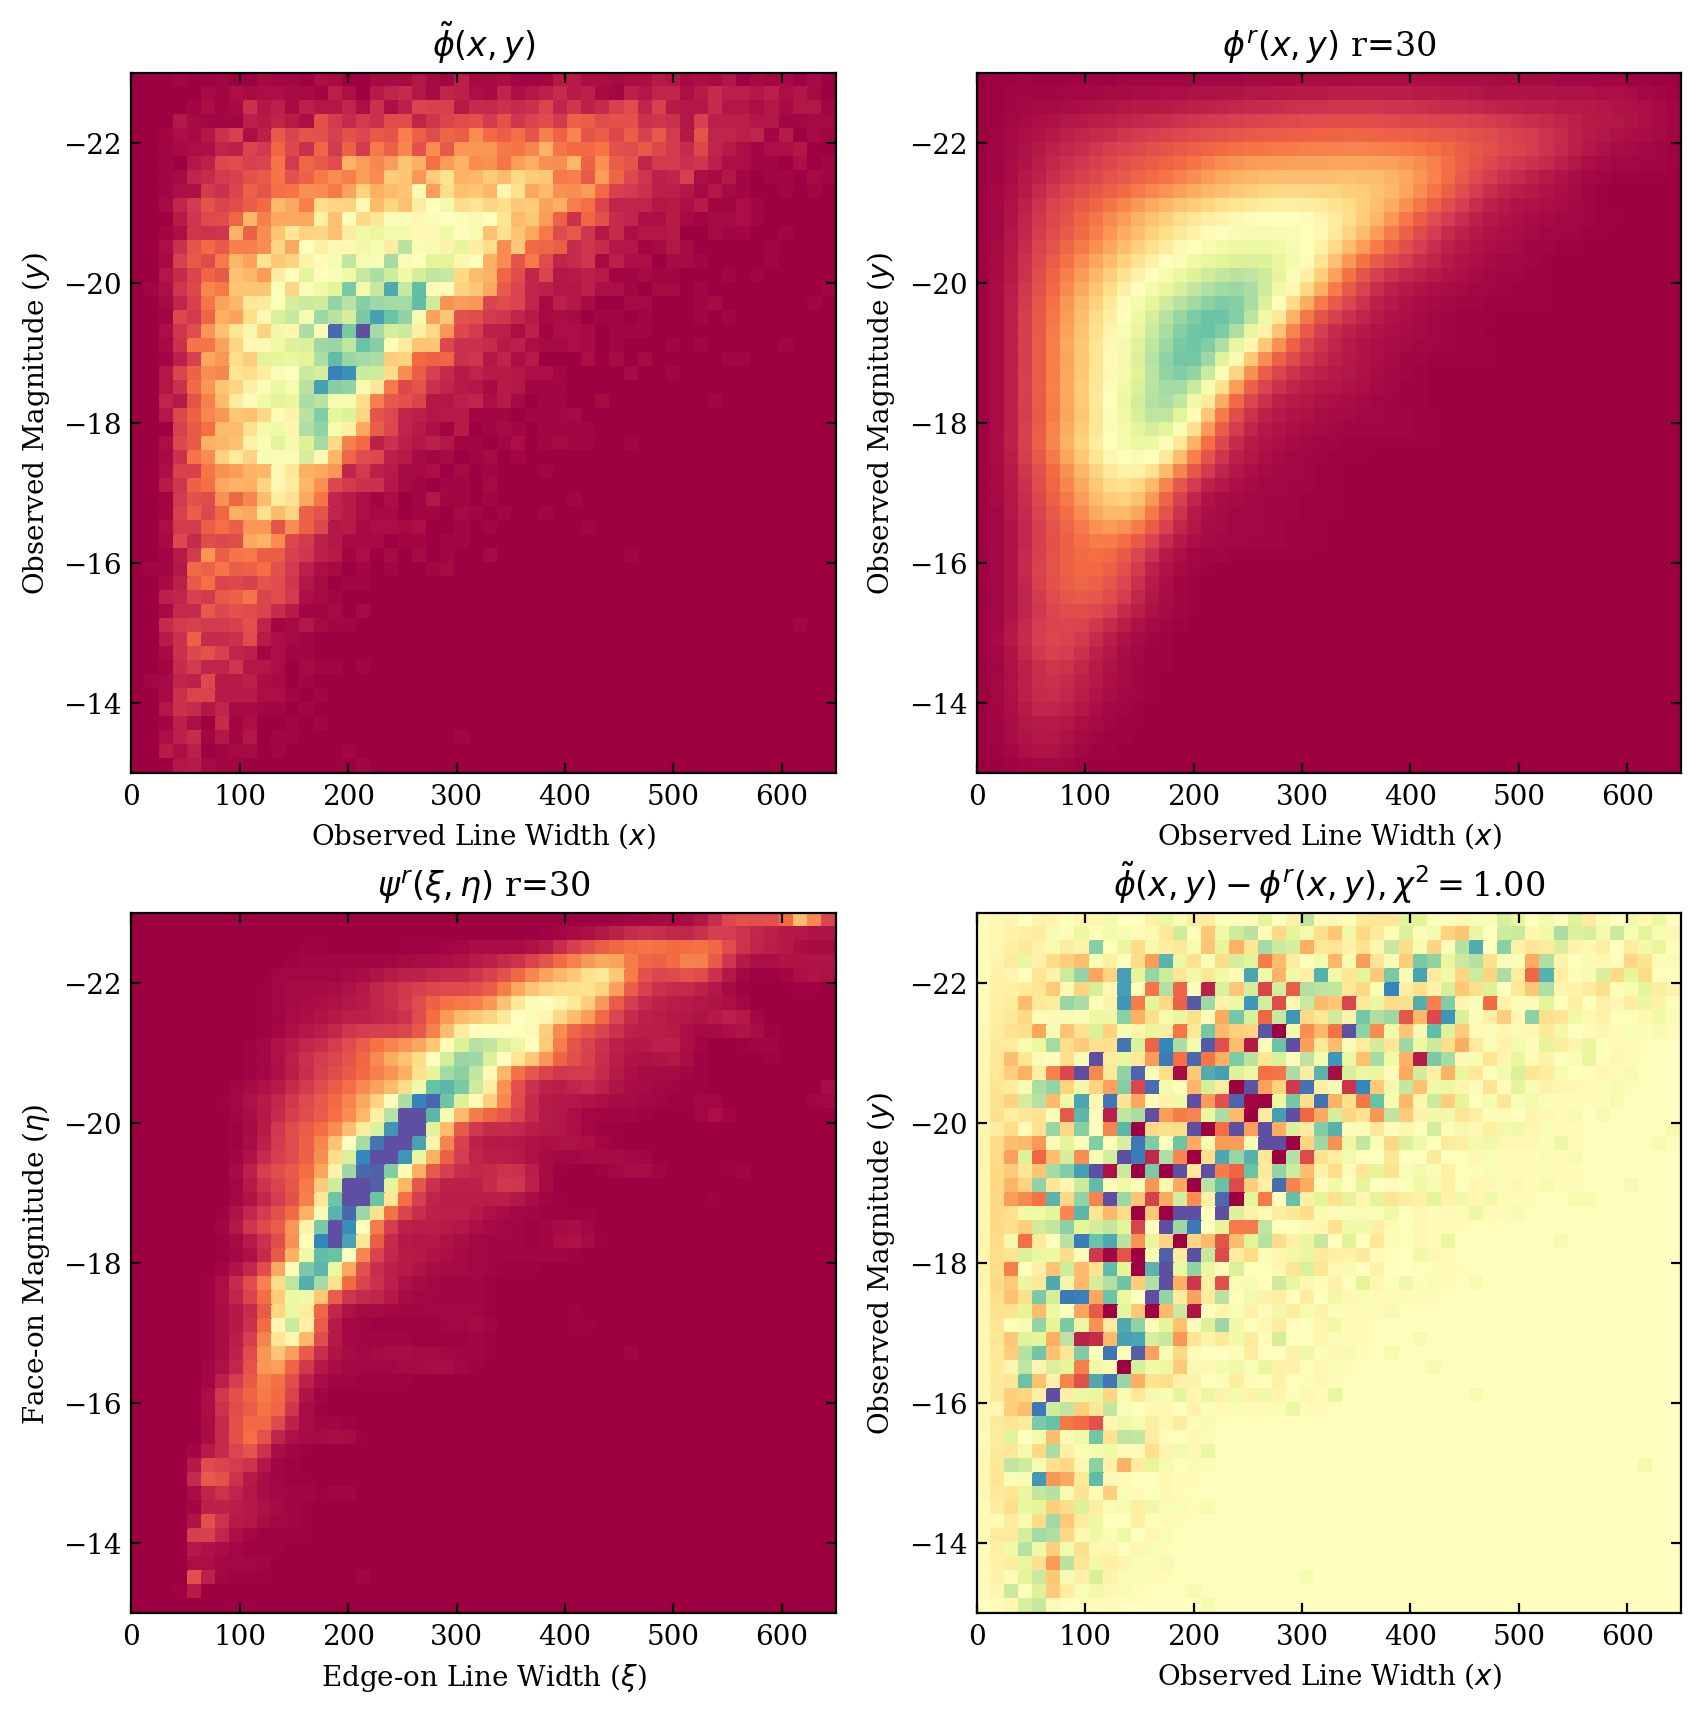

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# load all variables from .npz file as Global variables
def load_npz(npz_file, namespace):
    Data = np.load(npz_file)
    for varName in Data:
        namespace[varName] = Data[varName]

# Load the saved arrays from .npz file 
rundir = 'xsig20.0_ysig0.14_w30'
niter = 30
load_npz(rundir+f'/phi_psi_n{niter}.npz', globals())

# set up plotting grid
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

# set uniform contrast
xmin,xmax,ymin,ymax = 0,650,-23,-13
vmin,vmax = 0, phi_n.max()

X,Y = np.meshgrid(x_n,y_n)
ax[0,0].pcolormesh(X, Y, phi_n, cmap='Spectral', edgecolors='face', vmin=vmin, vmax=vmax)
ax[0,0].set_xlabel(xlabel)
ax[0,0].set_ylabel(ylabel)
ax[0,0].set_title('$\\tilde{\phi}(x,y)$')
ax[0,0].set_xlim(xmin,xmax)
ax[0,0].set_ylim(ymax,ymin)

ax[0,1].pcolormesh(X, Y, phi_r, cmap='Spectral', edgecolors='face', vmin=vmin, vmax=vmax)
ax[0,1].set_xlabel(xlabel)
ax[0,1].set_ylabel(ylabel)
ax[0,1].set_title('$\phi^r(x,y)$'+f' r={niter}')
ax[0,1].set_xlim(xmin,xmax)
ax[0,1].set_ylim(ymax,ymin)

ax[1,1].pcolormesh(X,Y,phi_n-phi_r,cmap='Spectral', edgecolors='face', vmin=-vmax/10,vmax=vmax/10)
ax[1,1].set_xlabel(xlabel)
ax[1,1].set_ylabel(ylabel)
ax[1,1].set_title('$\\tilde{\phi}(x,y) - \phi^r(x,y), \chi^2 =$'+f'{chisq1[-1]:.2f}') 
ax[1,1].set_xlim(xmin,xmax)
ax[1,1].set_ylim(ymax,ymin)

XI,ETA = np.meshgrid(xi_n,eta_n)
cb = ax[1,0].pcolormesh(XI, ETA, psi_r, cmap='Spectral', edgecolors='face', vmin=vmin, vmax=vmax*1.5) 
ax[1,0].set_xlabel(xilabel)
ax[1,0].set_ylabel(etalabel)
ax[1,0].set_title('$\psi^r(\\xi,\eta)$'+f' r={niter}')
ax[1,0].set_xlim(xmin,xmax)
ax[1,0].set_ylim(ymax,ymin)

# save plot as png file
plt.savefig(rundir+f'/n{niter}.png', bbox_inches='tight');